In [1]:
### 3.5.4.2　正解データを用いないクラスタリングの評価

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mglearn


In [2]:
from sklearn.datasets import make_blobs
# 合成2次元データを作る。
X, y = make_blobs(random_state=1)

# two_moonsデータ
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

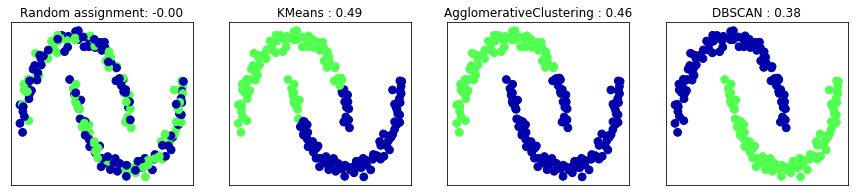

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import silhouette_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# データを平均0分散を1にスケール変換する
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
subplot_kw={'xticks': (), 'yticks': ()})

# 参照のためにランダムなクラスタ割り当てを作る
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# ランダムな割り当てをプロット
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
silhouette_score(X_scaled, random_clusters)))
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
DBSCAN()]
for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # クラスタ割り当てとクラスタセンタをプロット
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
    s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
    silhouette_score(X_scaled, clusters)))

people.images.shape: (3023, 87, 65)
Number of classes: 62
Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 Jo

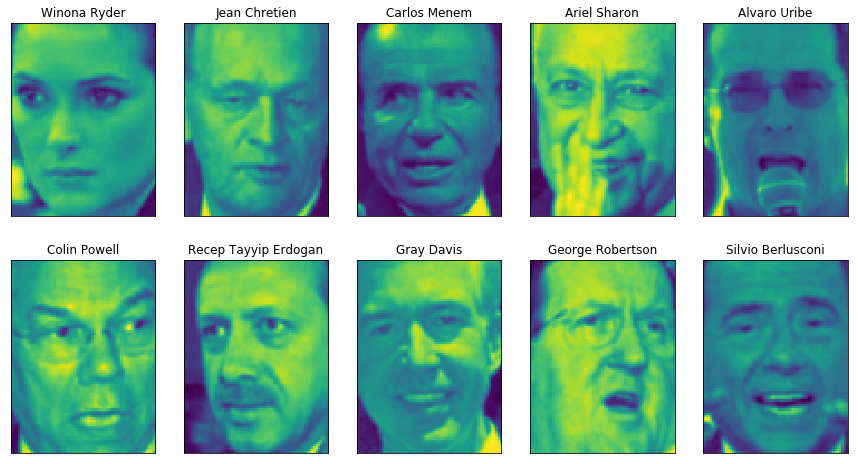

In [7]:
#### Labeled Faces in the Wildデータセットの顔画像
#### このデータセットは、インターネットから集めた有名人の顔画像で構成されている。
#### 2000年代初期からの政治家、歌手、俳優、運動選手などの顔画像だ。
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

# 各ターゲットの出現回数をカウント
counts = np.bincount(people.target)
# ターゲット名と出現回数を並べて表示
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# 0から255で表現されている、グレースケールの値0と1の間に変換
# こうしたほうが、数値的に安定する
X_people = X_people / 255.

In [9]:
### 3.5.4.3　顔画像データセットを用いたアルゴリズムの比較
# lfwデータから固有顔を抽出し、変換する
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [15]:
# デフォルト設定でDBSCANを適用する
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))
    ## 3点のグループをクラスタとしても、すべてがノイズになってしまった。epsを増やす必要がある。

Unique labels: [-1]


In [17]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))
    ## epsを15とずいぶん大きくしたところ、1つのクラスタとノイズだけになった。
    ## いくつのデータポイントがノイズで、いくつがクラスタ内なのかを見てみよう。

Unique labels: [-1  0]


In [18]:
# クラスタとノイズのデータポイント数を数える
# bincountは、負の数を許さないので、すべてに1を加える
# 結果の最初の数がノイズのデータポイント数に対応する
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  32 2031]


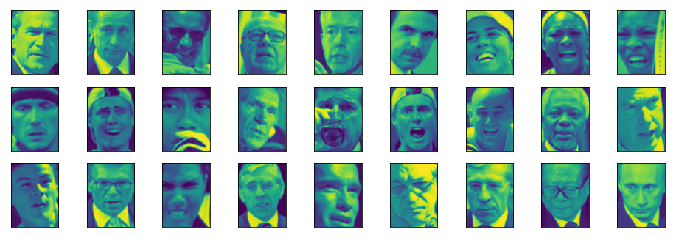

In [20]:
# ノイズを見る
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [22]:
## 1つの大きいクラスタではなく、もっと興味深いクラスタを見つけたいなら
## epsを小さくして、15と0.5（デフォルト値）の間のどこかにしなければならない。
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)

    labels = dbscan.fit_predict(X_pca)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))
    
    ## epsが小さいとすべてのデータポイントがノイズになる。eps=7では、大量のノイズと多数の小さいクラスタが得られる。eps=9でも大量のノイズがあるが、今度は大きいクラスタが1つといくつかの小さいクラスタが得られる。eps=11以降は大きいクラスタ1つとノイズになる。
    ## 興味深い点としては、大きいクラスタが1つ以上得られることはないことだ。一番良い場合でも、大きいクラスタにほとんどのデータポイントが属しており、他には小さいクラスタがいくつかあるだけだ。これは、データセットの中には、2種類や3種類の明らかに異なるようなグループがなく、すべての顔画像が同じように似ている（もしくは同じように似ていない）ということを意味している。



eps=1
Clusters present: [-1]
Cluster sizes: [2063]

eps=3
Clusters present: [-1]
Cluster sizes: [2063]

eps=5
Clusters present: [-1]
Cluster sizes: [2063]

eps=7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Clusters present: [-1  0  1  2]
Cluster sizes: [1308  749    3    3]

eps=11
Clusters present: [-1  0]
Cluster sizes: [ 415 1648]

eps=13
Clusters present: [-1  0]
Cluster sizes: [ 120 1943]


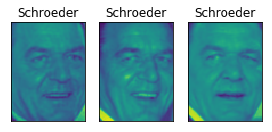

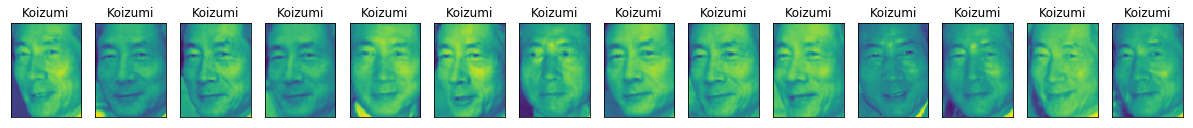

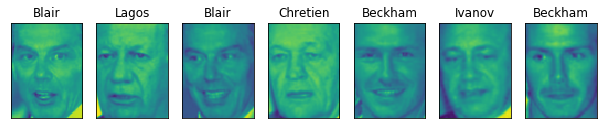

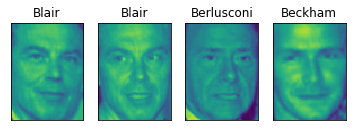

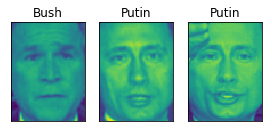

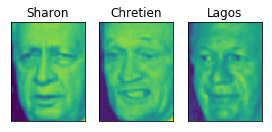

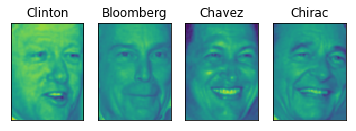

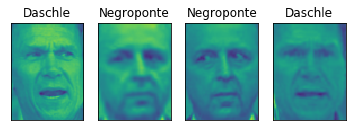

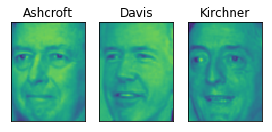

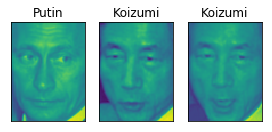

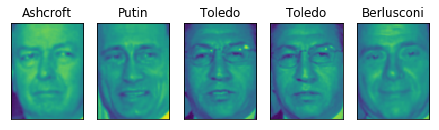

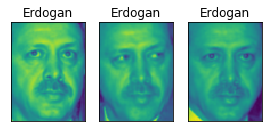

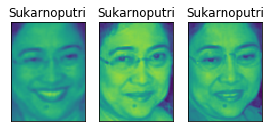

In [23]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
    subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
    ## クラスタのうちいくつかは、データセット中の特定の顔に対応している。
    ## SharonやKoizumiがそうだ。個々のクラスタ内では、顔の向きや位置、表情が一定している。
    ## いくつかのクラスタには複数の人物が含まれているが顔の向きや表情は類似している。